In [242]:
#import all required packages
import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits,ascii
from astropy.wcs import WCS
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.table import join

from photutils.aperture import SkyCircularAperture,SkyCircularAnnulus,aperture_photometry 
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog
from photutils.background import Background2D, MedianBackground, SExtractorBackground, MMMBackground
from photutils.utils import calc_total_error

In [243]:
#data path
dpath='C:/Users/mhankins1/Documents/SofiaLegacyProgram/SOFIA_Cycle7_Data/SgrAandNearby'
dpathalt='E:\Documents\SofiaLegacyProgram\CAL_files\CAL_C'

#file name
fname='F0590_FO_IMA_07018926_FORF253_CAL_0057-0086_Field_O.fits'

#Name of field
field='FieldO'

#wavelength of data
wavelength=25.2

In [244]:
#change directory to data location
try:
    os.chdir(dpath)
except:
    os.chdir(dpathalt)

#import data - unpack fits file into header, image (data), varance (varmap), and exposure time (tmap)
hdu=fits.open(fname)
header=hdu[0].header
ims=hdu[0].data
#np.shape(ims)
data=ims[0]
varmap=ims[1]
tmap=ims[2]
#wcsmap = WCS(header)
hdu.close()

#hack to make SOFIA wcs header work correctly with astropy.wcs
hdu[0].header['NAXIS']=2
wcsmap=WCS(hdu[0].header)

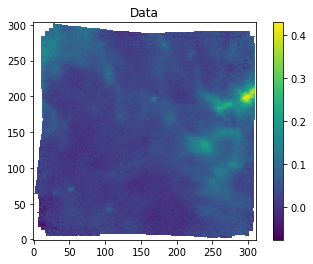

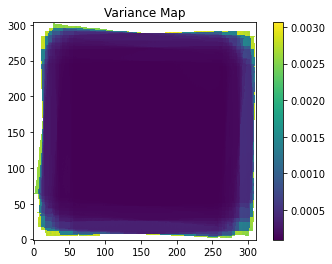

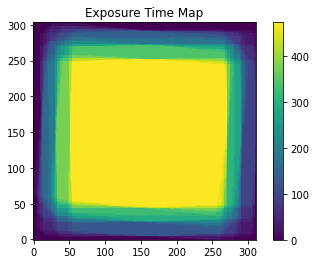

In [245]:
#take a quick look at the maps that were loaded in 
plt.figure()
plt.title('Data')
plt.imshow(data,origin='lower',interpolation='none')
plt.colorbar()
#plt.clim(0.0,0.1)
plt.show()

plt.figure()
plt.title('Variance Map')
plt.imshow(varmap,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Exposure Time Map')
plt.imshow(tmap,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

#create pixel error map by taking sqrt of variance map
errormap=np.sqrt(varmap)

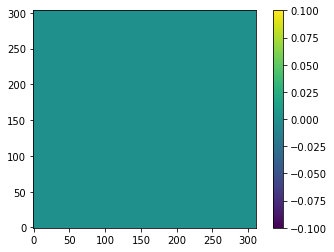

In [246]:
#create mask for edges of field where less integration time was collected
tmapnorm=tmap/np.max(tmap) #normalize the exposure time map
mask=np.where(tmapnorm<0.4,tmapnorm,0).astype('bool') #create mask for any locations with less than 50% of max exposure time -Can be modified as needed

#additional series of masks that can be applied when searching for sources in the segmentation map
mask2=np.zeros(np.shape(mask))  #mask 2 is applied to the first segmentation map instance for source detection
#mask2[0:100,0:250]=1

mask3=np.zeros(np.shape(mask))  #mask 3 is applied to the deblended segmentation map for source detection - this may or may not be needed if the first 2 masks work ok
#mask3[0:330,0:70]=1

#plot any of the masks to verify they are configured as needed
plt.figure()
plt.imshow(mask2,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

In [247]:
#create background model for image using median method
bkg_estimator = MedianBackground()
bkg_data = Background2D(data,(20, 20), filter_size=(3, 3),bkg_estimator=bkg_estimator,edge_method='pad') #smaller box?, 20x20, 25x25?
bkg_rms=bkg_data.background_rms
bkg=bkg_data.background 

#create background subtracted image
data_bkgsub = data - bkg

#set detection threshold for source finding based on modeled background rms
threshold = 3.0*bkg_rms

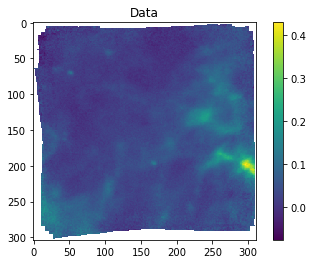

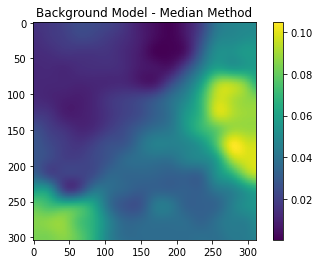

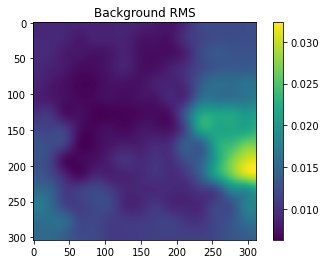

In [248]:
#take a look at data and bakground model images
plt.figure()
plt.title('Data')
plt.imshow(data,interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Background Model - Median Method')
plt.imshow(bkg,interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Background RMS')
plt.imshow(bkg_rms,interpolation='none')
plt.colorbar()
plt.show()

In [249]:
#do source detection. A 3x3 FWHM gaussian is used to smooth image prior to detection
sigma = 3.0 * gaussian_fwhm_to_sigma  # FWHM = 3.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
segm = detect_sources(data_bkgsub, threshold, mask=mask, npixels=5, filter_kernel=kernel)

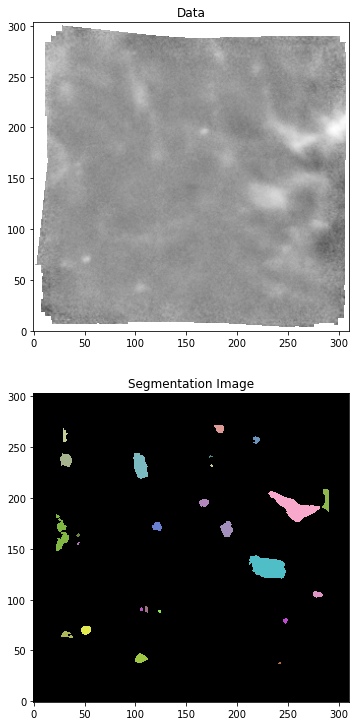

In [250]:
#removed labels that exist in masked region (mask2)
segm.remove_masked_labels(mask2.astype('bool'))

#make plot of segmentation image to show detected sources
norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data_bkgsub, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm.make_cmap(seed=123)
ax2.imshow(segm, origin='lower', cmap=cmap, interpolation='nearest')
ax2.set_title('Segmentation Image')
plt.show()

In [251]:
#now lets look at building a catalog and associated table from the seg map
cat = SourceCatalog(data_bkgsub, segm,background=bkg,wcs=wcsmap) #can also take in error and bkg measurements - this is done later

#specify the columns that we want for our table
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']

#create table
tbl = cat.to_table(columns)

#display table below
tbl

label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,242.214339166804,37.39299590537406,"266.46605528489874,-28.886114771351888",0.04507467963062602,0.0396723349892643,0.1983616749463215,5.0,0.7751991085860263,0.4488621150296075,17.736792762476647,1.9702766651803398,-1.9146536334110629,4.657141343400962,0.8153075417346539,0.4209718379987071,1.7270317155968782,1.4915613600094317,2.431910467521841,nan,3.7320015914702935,0.2257992302360401,nan
2,105.26450168712991,42.02067254908257,"266.49942264346413,-28.885128189315726",0.009869651182725644,0.016106185341530493,1.401238124713153,87.0,2.8750460938455515,2.1349299220567546,11.042807283828925,0.12458994764029038,-0.03700469591915045,0.21578720406535035,0.6697657859350258,0.2574275846822497,1.3466700073582658,5.96281536704808,7.866149615543381,nan,2.6425906650881372,3.3716969304831323,nan
3,32.50023714697645,65.5787515390038,"266.5171497717712,-28.880099471872622",0.01938134022465684,0.012350662999117044,0.5434291719611499,44.0,2.797722409598619,1.584176058955913,-14.291665690294215,0.1442554832128406,0.12951699816977047,0.3819709838799664,0.8242419570413339,0.43376224405937747,1.7660426022613427,5.353491743185683,3.725355147118419,nan,2.3820109973821832,1.452685368884006,nan
4,51.71136898679466,70.30201601007597,"266.5124690361107,-28.879092858340865",0.015093602515171963,0.01231083045470201,0.9110014536479488,74.0,2.3437499108406987,1.9276573440862548,18.22367186105653,0.1905599655764753,-0.05172808671118875,0.26060099245981255,0.5688125903003605,0.17753283523547625,1.2158540095473656,5.053003360715836,7.281841536443881,nan,2.6341645842699957,3.5989326438805094,nan
5,247.9041913215627,79.86112325201515,"266.46467077355305,-28.87705470068316",0.05685130216644814,0.07406737439383303,1.4813474878766606,20.0,1.3719586780129376,1.1628448366925472,63.864400187154175,0.69912125874673,-0.16471451242879825,0.5716831110511127,0.530667522625914,0.15241992683282435,1.1798295307525017,2.9946417556494875,8.434601107403923,nan,3.518270244457995,1.0036060497066903,nan
6,110.99419408878855,90.67678623668627,"266.498025370315,-28.874748356892987",0.013287351360918492,0.013758505835261404,0.20637758752892107,15.0,1.4505931228680988,0.7531246102367888,-77.00738758164273,1.6979620397448092,0.5642452739520363,0.5403302159434382,0.8546625456647574,0.48081608938851306,1.9260997491663696,2.72153281936165,2.628516104939687,nan,3.3348882700684896,0.3859386152904262,nan
7,124.08459110348853,89.14541318875405,"266.49483630569875,-28.875075309419884",0.012779747914352034,0.013783214966084461,0.11026571972867569,8.0,0.8828199186863933,0.6506596970795401,-48.88238202714169,1.8954649446521452,1.0690878491455889,1.7496878777016849,0.6758662889295012,0.26297574023057835,1.3568074411999007,1.82610870448241,2.1277417965632552,nan,3.6951400148298656,0.19281782300570885,nan
8,105.98121802070361,90.64265189868954,"266.4992466369966,-28.874755519583992",0.013150118108953304,0.01339031082034631,0.09373217574242418,7.0,0.7726261436764613,0.6842106914708458,6.076727550191227,1.6803441113044013,-0.09703670323617558,2.1309284587786337,0.46451542888946473,0.11443497340757813,1.1292225528010225,1.7184503403878428,1.9276166154079422,nan,3.6675342287464185,0.19227762022133998,nan


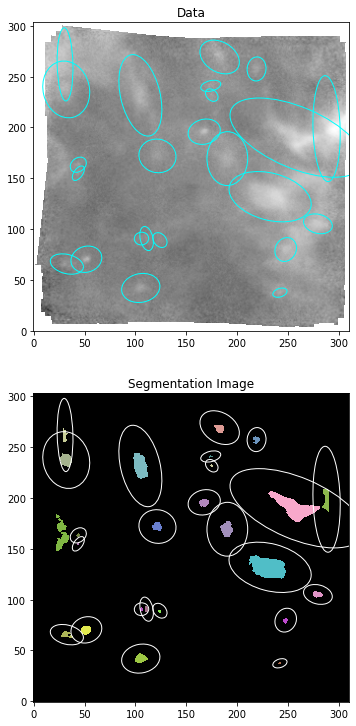

In [252]:
#overplot catalog sources on image - Note some sources may not have apertures plotted if kron aperture fails, but that's ok
norm = simple_norm(data, 'sqrt')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm.make_cmap(seed=123)
ax2.imshow(segm, origin='lower', cmap=cmap,interpolation='nearest')
ax2.set_title('Segmentation Image')
#try-except logic to catch any instances where kron aperture does something weird
for aperture in cat.kron_aperture:
    try:
        aperture.plot(axes=ax1, color='cyan', lw=1.)
        aperture.plot(axes=ax2, color='white', lw=1.)
    except:
        skip=1
plt.show()

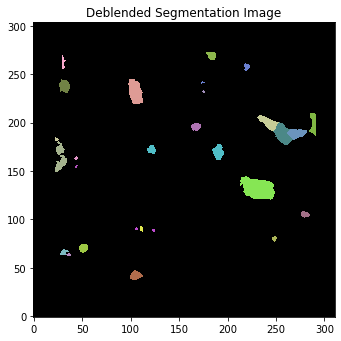

In [253]:
#lets take a look at deblending sources
segm_deblend = deblend_sources(data_bkgsub, segm, npixels=5,filter_kernel=kernel, nlevels=64,contrast=0.001)

#remove any sources that should be masked (mask3)
segm_deblend.remove_masked_labels(mask3.astype('bool'))

#plot the deblended image
plt.figure(figsize=(5.4, 8.5))
plt.imshow(segm_deblend, origin='lower', cmap=cmap, interpolation='nearest')
plt.title('Deblended Segmentation Image')
plt.show()

In [254]:
#now lets look at building a catalog and table from the deblended seg map
catde = SourceCatalog(data_bkgsub, segm_deblend,background=bkg,wcs=wcsmap)

#define which columns we want to have in the table
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']

#create table
tbl_deblend = catde.to_table(columns)

#display table
tbl_deblend

label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,242.214339166804,37.39299590537406,"266.46605528489874,-28.886114771351888",0.04507467963062602,0.0396723349892643,0.1983616749463215,5.0,0.7751991085860263,0.4488621150296075,17.736792762476647,1.9702766651803398,-1.9146536334110629,4.657141343400962,0.8153075417346539,0.4209718379987071,1.7270317155968782,1.4915613600094317,2.431910467521841,nan,3.7320015914702935,0.2257992302360401,nan
2,105.26450168712991,42.02067254908257,"266.49942264346413,-28.885128189315726",0.009869651182725644,0.016106185341530493,1.401238124713153,87.0,2.8750460938455515,2.1349299220567546,11.042807283828925,0.12458994764029038,-0.03700469591915045,0.21578720406535035,0.6697657859350258,0.2574275846822497,1.3466700073582658,5.96281536704808,7.866149615543381,nan,2.6425906650881372,3.3716969304831323,nan
3,51.71136898679466,70.30201601007597,"266.5124690361107,-28.879092858340865",0.015093602515171963,0.01231083045470201,0.9110014536479488,74.0,2.3437499108406987,1.9276573440862548,18.22367186105653,0.1905599655764753,-0.05172808671118875,0.26060099245981255,0.5688125903003605,0.17753283523547625,1.2158540095473656,5.053003360715836,7.281841536443881,nan,2.6341645842699957,3.5989326438805094,nan
4,247.9041913215627,79.86112325201515,"266.46467077355305,-28.87705470068316",0.05685130216644814,0.07406737439383303,1.4813474878766606,20.0,1.3719586780129376,1.1628448366925472,63.864400187154175,0.69912125874673,-0.16471451242879825,0.5716831110511127,0.530667522625914,0.15241992683282435,1.1798295307525017,2.9946417556494875,8.434601107403923,nan,3.518270244457995,1.0036060497066903,nan
5,110.99419408878855,90.67678623668627,"266.498025370315,-28.874748356892987",0.013287351360918492,0.013758505835261404,0.20637758752892107,15.0,1.4505931228680988,0.7531246102367888,-77.00738758164273,1.6979620397448092,0.5642452739520363,0.5403302159434382,0.8546625456647574,0.48081608938851306,1.9260997491663696,2.72153281936165,2.628516104939687,nan,3.3348882700684896,0.3859386152904262,nan
6,124.08459110348853,89.14541318875405,"266.49483630569875,-28.875075309419884",0.012779747914352034,0.013783214966084461,0.11026571972867569,8.0,0.8828199186863933,0.6506596970795401,-48.88238202714169,1.8954649446521452,1.0690878491455889,1.7496878777016849,0.6758662889295012,0.26297574023057835,1.3568074411999007,1.82610870448241,2.1277417965632552,nan,3.6951400148298656,0.19281782300570885,nan
7,105.98121802070361,90.64265189868954,"266.4992466369966,-28.874755519583992",0.013150118108953304,0.01339031082034631,0.09373217574242418,7.0,0.7726261436764613,0.6842106914708458,6.076727550191227,1.6803441113044013,-0.09703670323617558,2.1309284587786337,0.46451542888946473,0.11443497340757813,1.1292225528010225,1.7184503403878428,1.9276166154079422,nan,3.6675342287464185,0.19227762022133998,nan
8,279.60326335625354,105.16743283878561,"266.45694952462406,-28.871654620526538",0.0479750439141454,0.09263721847862677,4.076037613059578,44.0,2.304006165584612,1.4961657739856509,-14.608356351116178,0.2048125406491645,0.1261024728738999,0.4302918830549541,0.7604676926218213,0.3506242316821153,1.5399404301616573,4.574342170954153,7.064369288874987,nan,2.5039055746647243,2.6165943915590675,nan


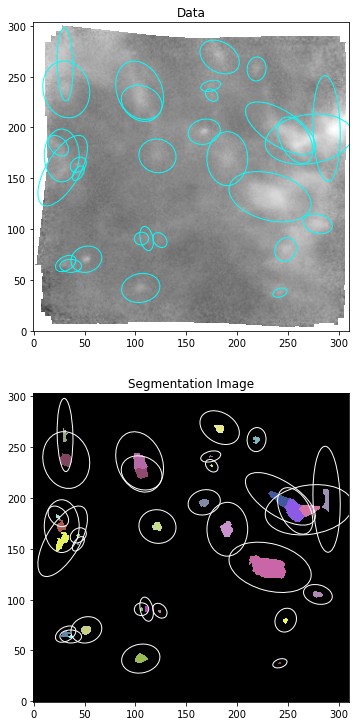

In [255]:
#overplot catalog sources on image - Note some sources may not have apertures plotted if kron aperture fails, but that's ok
norm = simple_norm(data, 'sqrt')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm_deblend.make_cmap(seed=123)
ax2.imshow(segm_deblend, origin='lower', cmap=cmap,interpolation='nearest')
ax2.set_title('Segmentation Image')
#try-except logic to catch any instances where kron aperture does something weird
for aperture in catde.kron_aperture:
    try:
        aperture.plot(axes=ax1, color='cyan', lw=1.)
        aperture.plot(axes=ax2, color='white', lw=1.)
    except:
        skip=1
plt.show()

In [256]:
#what if we wanted to include errors? - Not completely sure this is implemented correctly for our observations, but we'll use it for now...
calfactor = header['CALFCTR'] # units are (Me/sec/Jy)
gainfactor=tmap*calfactor*1e6 #gain in electrons/Jy
#errormap=calc_total_error(data,bkg,gainfactor) #use the varmap instead. Its probably more appropriate for our data type. 

#now lets look at building a catalog from the seg map
catwerr = SourceCatalog(data_bkgsub, segm_deblend,background=bkg,error=errormap,wcs=wcsmap)
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','background','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']#,'kron_aperture']
tbl2 = catwerr.to_table(columns)

In [257]:
#calculate statistics for background cutouts in table
segbkg_median=[]
segbkg_mean=[]
segbkg_std=[]

#loop through each cutout and use sigma_cliped_stats to get mean, median, and std
for i in range (0,len(tbl2['background'])):
    bkgdata=tbl2['background'][i]
    meansc, median_sigclip, stdsc = sigma_clipped_stats(bkgdata)
    segbkg_median.append(median_sigclip)
    segbkg_mean.append(meansc)
    segbkg_std.append(stdsc)

#add the above calculated information to our table
tbl2['segbkg_mean_sc']=segbkg_mean
tbl2['segbkg_median_sc']=segbkg_median
tbl2['segbkg_std_sc']=segbkg_std  

#remove the 2d background array to tidy up the table
tbl2.remove_column('background')

In [258]:
#calculate noise stats
#sky noise from background
skynoise=np.sqrt(tbl2['segbkg_median_sc']*tbl2['area']/u.pix**2)
#replace any nan values with zero
sna=np.array(skynoise)
masknan=np.isnan(sna)
sna[masknan]=0.0
skynoise=sna**2

#shot noise from the source
sourcenoise=tbl2['segment_flux']

#thermal noise from camera (from error map)
thermalnoise=tbl2['segment_fluxerr']

#total noise
#totalnoise=np.sqrt(sourcenoise+thermalnoise+skynoise) #includes all noise sources
totalnoise=np.sqrt(thermalnoise+skynoise) #no shot noise -> For some reason this seems to work much better for the apertures. Need to think about why this is a bit more...

#calculate SNR for the segments
tbl2['segmentSNR']=tbl2['segment_flux']/ totalnoise 

#display table
tbl2

label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64
1,242.214339166804,37.39299590537406,"266.46605528489874,-28.886114771351888",0.04507467963062602,0.0396723349892643,0.1983616749463215,5.0,0.7751991085860263,0.4488621150296075,17.736792762476647,1.9702766651803398,-1.9146536334110629,4.657141343400962,0.8153075417346539,0.4209718379987071,1.7270317155968782,1.4915613600094317,2.431910467521841,0.11746730846180911,3.7320015914702935,0.2257992302360401,0.0265656,0.03949115078558957,0.039501385475190116,0.0009153658359217108,0.4770107324564301
2,105.26450168712991,42.02067254908257,"266.49942264346413,-28.885128189315726",0.009869651182725644,0.016106185341530493,1.401238124713153,87.0,2.8750460938455515,2.1349299220567546,11.042807283828925,0.12458994764029038,-0.03700469591915045,0.21578720406535035,0.6697657859350258,0.2574275846822497,1.3466700073582658,5.96281536704808,7.866149615543381,0.34760448134948,2.6425906650881372,3.3716969304831323,0.11277729,0.01600511786990101,0.016016114311129453,0.00037458346788777854,2.7473260378984508
3,51.71136898679466,70.30201601007597,"266.5124690361107,-28.879092858340865",0.015093602515171963,0.01231083045470201,0.9110014536479488,74.0,2.3437499108406987,1.9276573440862548,18.22367186105653,0.1905599655764753,-0.05172808671118875,0.26060099245981255,0.5688125903003605,0.17753283523547625,1.2158540095473656,5.053003360715836,7.281841536443881,0.2662883072826548,2.6341645842699957,3.5989326438805094,0.09346459,0.012336727339461048,0.012304043944438363,0.0002465583193131258,3.5918209779735526
4,247.9041913215627,79.86112325201515,"266.46467077355305,-28.87705470068316",0.05685130216644814,0.07406737439383303,1.4813474878766606,20.0,1.3719586780129376,1.1628448366925472,63.864400187154175,0.69912125874673,-0.16471451242879825,0.5716831110511127,0.530667522625914,0.15241992683282435,1.1798295307525017,2.9946417556494875,8.434601107403923,0.19643138903728663,3.518270244457995,1.0036060497066903,0.044573065,0.07375651373286625,0.07362442803431818,0.002544946165937769,0.8148199601520111
5,110.99419408878855,90.67678623668627,"266.498025370315,-28.874748356892987",0.013287351360918492,0.013758505835261404,0.20637758752892107,15.0,1.4505931228680988,0.7531246102367888,-77.00738758164273,1.6979620397448092,0.5642452739520363,0.5403302159434382,0.8546625456647574,0.48081608938851306,1.9260997491663696,2.72153281936165,2.628516104939687,0.15530331629665958,3.3348882700684896,0.3859386152904262,0.038971838,0.01372794746203403,0.013702894187527244,0.0003946257914274262,0.7804862540840986
6,124.08459110348853,89.14541318875405,"266.49483630569875,-28.875075309419884",0.012779747914352034,0.013783214966084461,0.11026571972867569,8.0,0.8828199186863933,0.6506596970795401,-48.88238202714169,1.8954649446521452,1.0690878491455889,1.7496878777016849,0.6758662889295012,0.26297574023057835,1.3568074411999007,1.82610870448241,2.1277417965632552,0.12411342942286835,3.6951400148298656,0.19281782300570885,0.028295184,0.013751170717843266,0.013746938526305865,0.00023201697337229085,0.5185398137770174
7,105.98121802070361,90.64265189868954,"266.4992466369966,-28.874755519583992",0.013150118108953304,0.01339031082034631,0.09373217574242418,7.0,0.7726261436764613,0.6842106914708458,6.076727550191227,1.6803441113044013,-0.09703670323617558,2.1309284587786337,0.46451542888946473,0.11443497340757813,1.1292225528010225,1.7184503403878428,1.9276166154079422,0.1190484988288965,3.

In [259]:
#now lets look at performing some aperture photometry on the data.... Lets get the source centroids from the segmentaion map table
sourcecoords=tbl2['sky_centroid']

In [260]:
#first let's do some simple annulus extractions...   
radii = [2,4,6,8,10] #define aperture radii & construct apertures (line below)
apertures =[SkyCircularAperture(sourcecoords, r=r*u.arcsec) for r in radii] # for pixels: r=r*u.arcsec*0.786

#do aperture photometry on data using defined apertures 
phot_table = aperture_photometry(data_bkgsub, apertures,wcs=wcsmap,error=errormap,method='exact')

#display phot table
phot_table

id,xcenter,ycenter,sky_center,aperture_sum_0,aperture_sum_err_0,aperture_sum_1,aperture_sum_err_1,aperture_sum_2,aperture_sum_err_2,aperture_sum_3,aperture_sum_err_3,aperture_sum_4,aperture_sum_err_4
,pix,pix,"deg,deg",,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,242.21433916688179,37.39299590541239,"266.46605528489874,-28.886114771351888",0.7467208681169638,0.05531909021665616,2.2181276110270276,0.11107681968398485,3.950981062990266,0.16616770270161083,5.23654271530257,0.22286332277331483,5.562194122551228,0.281360829551303
2,105.26450168721274,42.02067254907121,"266.49942264346413,-28.885128189315726",1.088658863458493,0.05565388942101885,3.2579186104849813,0.11168240520337158,4.843111465148169,0.16676865369423358,6.039789915348539,0.22100512868706673,7.016452237517008,0.27554080577556356
3,51.711368986722434,70.3020160100832,"266.5124690361107,-28.879092858340865",1.6018117515325376,0.05018687054088669,3.76867931545944,0.10008293619064007,4.799955021176856,0.1494372867475834,5.597891904298532,0.1987416354384823,6.823565031650155,0.2479881754147709
4,247.90419132142563,79.8611232520409,"266.46467077355305,-28.87705470068316",1.0620500169831382,0.046011533171821176,3.208484513654654,0.09205488415429494,5.407111073127089,0.1380980527091202,7.702116878778334,0.1841948013151558,10.463823469638452,0.23051493699978248
5,110.99419408887785,90.67678623672421,"266.498025370315,-28.874748356892987",0.5226815486736636,0.04644923899859584,1.7087108345168793,0.09286238909971536,2.8687862232782493,0.13925412529725342,3.800159233241182,0.1855908588627767,5.152791749377419,0.23192909513892587
6,124.08459110360646,89.14541318879085,"266.49483630569875,-28.875075309419884",0.4819298805630208,0.046178294880869566,1.4018729730714539,0.09233982417750536,2.536694015683089,0.1384768711661673,3.823492645587794,0.18459888678352068,5.220870791081981,0.23069934633664735
7,105.98121802081222,90.64265189876703,"266.4992466369966,-28.874755519583992",0.4734772464110242,0.04650940409462853,1.4249034261511668,0.09298859547405931,2.514398504751899,0.13948526245877046,3.446803742455386,0.1859541699726409,4.238805631225771,0.23239567219752708
8,279.60326335619385,105.16743283879083,"266.45694952462406,-28.871654620526538",1.3119505196369339,0.05888988240227079,4.157156762170238,0.11840649797024395,6.598732780432045,0.18265834245423176,7.955805352463079,0.2574332482243797,7.192720152720556,0.33697970025663704


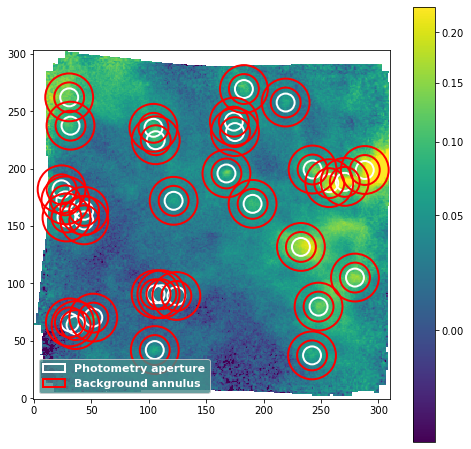

In [261]:
#now try photometry with local background subtraction
aperture2 =SkyCircularAperture(sourcecoords, r=6*u.arcsec) #define aperture
annulus_aperture = SkyCircularAnnulus(sourcecoords, r_in=10*u.arcsec, r_out=16*u.arcsec) #define annulus

#convert to pixel coords for plotting
pix_aperture = aperture2.to_pixel(wcsmap)
pix_annulus_aperture = annulus_aperture.to_pixel(wcsmap)


#show figure with apertures overlayed
plt.figure(figsize=(8,8))
norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm, interpolation='nearest',origin='lower')
plt.colorbar()
#plt.xlim(40, 140)
#plt.ylim(50, 125)

ap_patches = pix_aperture.plot(color='white', lw=2,
                           label='Photometry aperture')
ann_patches = pix_annulus_aperture.plot(color='red', lw=2,
                                    label='Background annulus')
handles = (ap_patches[0], ann_patches[0])
plt.legend(loc='best', facecolor='#458989', labelcolor='white',
           handles=handles, prop={'weight': 'bold', 'size': 11})
plt.show()

In [262]:
#now lets do robust statistics on the background annuli

#create lists to store information for later
bkg_median=[]
bkg_mean=[]
bkg_std=[]
appmasks=[]

#create mask array for the annuli
annulus_masks = pix_annulus_aperture.to_mask(method='exact')

#for each of the annuli loop through and calculate stats using sigma cliped stats
for mask in annulus_masks:
    annulus_data = mask.multiply(data_bkgsub)
    
    #this is a bit of debugging to handle if the mask array is the wrong shape
    if np.shape(mask.data)[0]==41:
        maskdata=mask.data[:-1,:]
    else:
        maskdata=mask.data
        
    #do statistics
    annulus_data_1d = annulus_data[maskdata > 0]
    meansc, median_sigclip, stdsc = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)
    bkg_mean.append(meansc)
    bkg_std.append(stdsc)
    appmasks.append(mask.data)

#store values in numpy arrays
bkg_median = np.array(bkg_median)
bkg_mean = np.array(bkg_mean)
bkg_std = np.array(bkg_std)

In [263]:
#do aperture photometry
phot_table2 = aperture_photometry(data_bkgsub, aperture2,wcs=wcsmap,error=errormap,method='exact') #

#add columns for background information and also background subtracted apertures
phot_table2['ann_bkg_med'] = bkg_median
phot_table2['ann_bkg_mean'] = bkg_mean 
phot_table2['aper_sum_bkgsub_6as'] = (phot_table2['aperture_sum']/pix_aperture.area - phot_table2['ann_bkg_med'])* pix_aperture.area 
phot_table2['aper_sum_bkgsub_err_6as'] = phot_table2['aperture_sum_err'] # should this be modified by bkgsub in some way?
#not sure if the above is right for the error array...

#calculate sky noise for 6 pixel aperture
skynoise=np.sqrt(phot_table2['ann_bkg_med']*pix_aperture.area)
sna=np.array(skynoise)
masknan=np.isnan(sna)
sna[masknan]=0.0
skynoise=sna**2

#store per pix sky noise for later
phot_table2['skynoise_pix']=skynoise/pix_aperture.area

#shot noise from the source
sourcenoise=phot_table2['aper_sum_bkgsub_6as']

#thermal noise from camera (from error map)
thermalnoise=phot_table2['aperture_sum_err']

#compute total noise 
#totalnoise=np.sqrt(sourcenoise+thermalnoise+skynoise) #all noise sources
#totalnoise=np.sqrt(thermalnoise+skynoise) # no shot noise -> For some reason this seems to give more 'reasonable' values. Need to think about why this is a bit more...
totalnoise=np.sqrt((thermalnoise+skynoise)*(1+pix_aperture.area/pix_annulus_aperture.area)) #modified to account for pixel stats

#SNR calc for 6 pixel aperture
phot_table2['aper_snr_6as']=phot_table2['aper_sum_bkgsub_6as']/totalnoise

#display new table
phot_table2

<ipython-input-263-d3b3f743c6c3>:12: RuntimeWarning: invalid value encountered in sqrt
  skynoise=np.sqrt(phot_table2['ann_bkg_med']*pix_aperture.area)


id,xcenter,ycenter,sky_center,aperture_sum,aperture_sum_err,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,aper_snr_6as
,pix,pix,"deg,deg",,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64
1,242.21433916688179,37.39299590541239,"266.46605528489874,-28.886114771351888",3.950981062990266,0.16616770270161083,-0.0014166676183446627,-0.0017503075163528847,4.22262367195785,0.16616770270161083,0.0,9.337288012205548
2,105.26450168721274,42.02067254907121,"266.49942264346413,-28.885128189315726",4.843111465148169,0.16676865369423358,0.00046747083331081423,0.0011826142449918688,4.753475057050426,0.16676865369423358,0.0004674708333108141,8.461738638338621
3,51.711368986722434,70.3020160100832,"266.5124690361107,-28.879092858340865",4.799955021176856,0.1494372867475834,0.0010172934016231636,0.0022668981539179867,4.604891457837051,0.1494372867475834,0.0010172934016231636,7.071897114956247
4,247.90419132142563,79.8611232520409,"266.46467077355305,-28.87705470068316",5.407111073127089,0.1380980527091202,0.010406612192351136,0.011148082839878937,3.411668211415279,0.1380980527091202,0.010406612192351138,2.10536784595705
5,110.99419408887785,90.67678623672421,"266.498025370315,-28.874748356892987",2.8687862232782493,0.13925412529725342,0.0007286519592696428,0.0016955413977183893,2.7290689623750697,0.13925412529725342,0.0007286519592696429,4.6574303063655496
6,124.08459110360646,89.14541318879085,"266.49483630569875,-28.875075309419884",2.536694015683089,0.1384768711661673,0.001355798438250943,0.001793638569796074,2.276722925618222,0.1384768711661673,0.0013557984382509428,3.251142916955414
7,105.98121802081222,90.64265189876703,"266.4992466369966,-28.874755519583992",2.514398504751899,0.13948526245877046,1.8204423069515e-05,0.0006702558205570464,2.5109078504069293,0.13948526245877046,1.8204423069515e-05,5.9856458053947295
8,279.60326335619385,105.16743283879083,"266.45694952462406,-28.871654620526538",6.598732780432045,0.18265834245423176,-0.008791976225181079,-0.012698589964688154,8.284573078369954,0.18265834245423176,0.0,17.472782138587046


In [264]:
#fix id keyword in tbl2 so these can be merged with the phot table results
try:
    tbl2.rename_column('label', 'id')
except:
    print('Do nothing because keyword is already changed.')

In [265]:
#merge the two photometry tables
merged_table = join(phot_table, phot_table2, keys='id')

#merge the segmentation map table with the combined phot table
merged_table_2 = join(tbl2,merged_table, keys='id')

#drop repeat columns
merged_table_2.remove_columns(['xcenter_1','ycenter_1','xcenter_2','ycenter_2','sky_center_1','sky_center_2','aperture_sum','aperture_sum_err'])

#rename some columns to avoid possible confusion
merged_table_2.rename_column('aperture_sum_0', 'aperture_sum_2as')
merged_table_2.rename_column('aperture_sum_err_0', 'aperture_sum_err_2as')
merged_table_2.rename_column('aperture_sum_1', 'aperture_sum_4as')
merged_table_2.rename_column('aperture_sum_err_1', 'aperture_sum_err_4as')
merged_table_2.rename_column('aperture_sum_2', 'aperture_sum_6as')
merged_table_2.rename_column('aperture_sum_err_2', 'aperture_sum_err_6as')
merged_table_2.rename_column('aperture_sum_3', 'aperture_sum_8as')
merged_table_2.rename_column('aperture_sum_err_3', 'aperture_sum_err_8as')
merged_table_2.rename_column('aperture_sum_4', 'aperture_sum_10as')
merged_table_2.rename_column('aperture_sum_err_4', 'aperture_sum_err_10as')


#compute area for the different size apertures 
ap2area=pix_aperture.area*(2./6.)**2
ap4area=pix_aperture.area*(4./6.)**2
#ap6area=pix_aperture.area*(6./6.)**2
ap8area=pix_aperture.area*(8./6.)**2
ap10area=pix_aperture.area*(10./6.)**2


#calculate local bkg subtracted photometry for the other apertures 
merged_table_2['aper_sum_bkgsub_2as']=(merged_table_2['aperture_sum_2as']/ap2area-merged_table_2['ann_bkg_med'])*ap2area
merged_table_2['aper_sum_bkgsub_4as']=(merged_table_2['aperture_sum_4as']/ap4area-merged_table_2['ann_bkg_med'])*ap4area
#merged_table_2['aper_sum_bkgsub_6as']=(merged_table_2['aperture_sum_6as']/ap6area-merged_table_2['ann_bkg_med'])*ap6area
merged_table_2['aper_sum_bkgsub_8as']=(merged_table_2['aperture_sum_8as']/ap8area-merged_table_2['ann_bkg_med'])*ap8area
merged_table_2['aper_sum_bkgsub_10as']=(merged_table_2['aperture_sum_10as']/ap10area-merged_table_2['ann_bkg_med'])*ap10area

#calculate snr for each aperture
merged_table_2['aper_snr_2as']=merged_table_2['aper_sum_bkgsub_2as']/np.sqrt((merged_table_2['aperture_sum_err_2as']+merged_table_2['skynoise_pix']*ap2area)*(1+ap2area/pix_annulus_aperture.area))
merged_table_2['aper_snr_4as']=merged_table_2['aper_sum_bkgsub_4as']/np.sqrt((merged_table_2['aperture_sum_err_4as']+merged_table_2['skynoise_pix']*ap4area)*(1+ap4area/pix_annulus_aperture.area))
#merged_table_2['aper_snr_6as']=merged_table_2['aper_sum_bkgsub_6as']/np.sqrt((merged_table_2['aperture_sum_err_6as']+merged_table_2['skynoise_pix']*ap6area)*(1+ap6area/pix_annulus_aperture.area))
merged_table_2['aper_snr_8as']=merged_table_2['aper_sum_bkgsub_8as']/np.sqrt((merged_table_2['aperture_sum_err_8as']+merged_table_2['skynoise_pix']*ap8area)*(1+ap8area/pix_annulus_aperture.area))
merged_table_2['aper_snr_10as']=merged_table_2['aper_sum_bkgsub_10as']/np.sqrt((merged_table_2['aperture_sum_err_10as']+merged_table_2['skynoise_pix']*ap10area)*(1+ap10area/pix_annulus_aperture.area))

#calculate max snr for all apertures
snr_values=np.array(merged_table_2['aper_snr_2as','aper_snr_4as','aper_snr_6as','aper_snr_8as','aper_snr_10as'])
snr_values.dtype=np.float
snr_values=np.reshape(snr_values, (-1,5))
maxsnr=np.nanmax(snr_values,axis=1)
merged_table_2['aper_snr_max']=maxsnr

#add additonal information for wavelength and which field 
merged_table_2['Field']='C7'+field
merged_table_2['wv']=wavelength

#display table
merged_table_2

id,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,aperture_sum_2as,aperture_sum_err_2as,aperture_sum_4as,aperture_sum_err_4as,aperture_sum_6as,aperture_sum_err_6as,aperture_sum_8as,aperture_sum_err_8as,aperture_sum_10as,aperture_sum_err_10as,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,aper_snr_6as,aper_sum_bkgsub_2as,aper_sum_bkgsub_4as,aper_sum_bkgsub_8as,aper_sum_bkgsub_10as,aper_snr_2as,aper_snr_4as,aper_snr_8as,aper_snr_10as,aper_snr_max,Field,wv
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64
1,242.214339166804,37.39299590537406,"266.46605528489874,-28.886114771351888",0.04507467963062602,0.0396723349892643,0.1983616749463215,5.0,0.7751991085860263,0.4488621150296075,17.736792762476647,1.9702766651803398,-1.9146536334110629,4.657141343400962,0.8153075417346539,0.4209718379987071,1.7270317155968782,1.4915613600094317,2.431910467521841,0.11746730846180911,3.7320015914702935,0.2257992302360401,0.0265656,0.03949115078558957,0.039501385475190116,0.0009153658359217108,0.4770107324564301,0.7467208681169638,0.05531909021665616,2.2181276110270276,0.11107681968398485,3.950981062990266,0.16616770270161083,5.23654271530257,0.22286332277331483,5.562194122551228,0.281360829551303,-0.0014166676183446627,-0.0017503075163528847,4.22262367195785,0.16616770270161083,0.0,9.337288012205548,0.7769033802244731,2.338857659457065,5.7194629090227185,6.31675692523896,3.2616083054746925,6.683287582681866,10.202037276131538,9.296182986298763,10.202037276131538,C7FieldO,25.2
2,105.26450168712991,42.02067254908257,"266.49942264346413,-28.885128189315726",0.009869651182725644,0.016106185341530493,1.401238124713153,87.0,2.8750460938455515,2.1349299220567546,11.042807283828925,0.12458994764029038,-0.03700469591915045,0.21578720406535035,0.6697657859350258,0.2574275846822497,1.3466700073582658,5.96281536704808,7.866149615543381,0.34760448134948,2.6425906650881372,3.3716969304831323,0.11277729,0.01600511786990101,0.016016114311129453,0.00037458346788777854,2.7473260378984508,1.088658863458493,0.05565388942101885,3.2579186104849813,0.11168240520337158,4.843111465148169,0.16676865369423358,6.039789915348539,0.22100512868706673,7.016452237517008,0.27554080577556356,0.00046747083331081423,0.0011826142449918688,4.753475057050426,0.16676865369423358,0.0004674708333108141,8.461738638338621,1.078699262558744,3.2180802068859844,5.880436300952551,6.7674622150232775,4.158207135315519,7.873336259420772,8.029043426385496,7.294283642780626,8.461738638338621,C7FieldO,25.2
3,51.71136898679466,70.30201601007597,"266.5124690361107,-28.879092858340865",0.015093602515171963,0.01231083045470201,0.9110014536479488,74.0,2.3437499108406987,1.9276573440862548,18.22367186105653,0.1905599655764753,-0.05172808671118875,0.26060099245981255,0.5688125903003605,0.17753283523547625,1.2158540095473656,5.053003360715836,7.281841536443881,0.2662883072826548,2.6341645842699957,3.5989326438805094,0.09346459,0.012336727339461048,0.012304043944438363,0.0002465583193131258,3.5918209779735526,1.6018117515325376,0.05018687054088669,3.76867931545944,0.10008293619064007,4.799955021176856,0.1494372867475834,5.597891904298532,0.1987416354384823,6.823565031650155,0.2479881754147709,0.0010172934016231636,0.0022668981539179867,4.6048914578

In [266]:
#write out the resulting table to file
ascii.write(merged_table_2, field+'_25um_cat.dat', overwrite=True)

In [267]:
#add simple quality cuts to saved sources
snrcut=merged_table_2['aper_snr_max']>=3.0 #max snr in all computed apertures must be gtreq to 3.0
fwhmcut=merged_table_2['fwhm']>=2.5*u.pix #fwhm measures must be greater than 2.5 pixels (~1.9")
keepconditions=(snrcut&fwhmcut) #conditions to keep a source
mtcut=merged_table_2[keepconditions] #apply conditions

#display new table with simple quality cuts
mtcut

id,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,aperture_sum_2as,aperture_sum_err_2as,aperture_sum_4as,aperture_sum_err_4as,aperture_sum_6as,aperture_sum_err_6as,aperture_sum_8as,aperture_sum_err_8as,aperture_sum_10as,aperture_sum_err_10as,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,aper_snr_6as,aper_sum_bkgsub_2as,aper_sum_bkgsub_4as,aper_sum_bkgsub_8as,aper_sum_bkgsub_10as,aper_snr_2as,aper_snr_4as,aper_snr_8as,aper_snr_10as,aper_snr_max,Field,wv
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64
2,105.26450168712991,42.02067254908257,"266.49942264346413,-28.885128189315726",0.009869651182725644,0.016106185341530493,1.401238124713153,87.0,2.8750460938455515,2.1349299220567546,11.042807283828925,0.12458994764029038,-0.03700469591915045,0.21578720406535035,0.6697657859350258,0.2574275846822497,1.3466700073582658,5.96281536704808,7.866149615543381,0.34760448134948,2.6425906650881372,3.3716969304831323,0.11277729,0.01600511786990101,0.016016114311129453,0.00037458346788777854,2.7473260378984508,1.088658863458493,0.05565388942101885,3.2579186104849813,0.11168240520337158,4.843111465148169,0.16676865369423358,6.039789915348539,0.22100512868706673,7.016452237517008,0.27554080577556356,0.00046747083331081423,0.0011826142449918688,4.753475057050426,0.16676865369423358,0.0004674708333108141,8.461738638338621,1.078699262558744,3.2180802068859844,5.880436300952551,6.7674622150232775,4.158207135315519,7.873336259420772,8.029043426385496,7.294283642780626,8.461738638338621,C7FieldO,25.2
3,51.71136898679466,70.30201601007597,"266.5124690361107,-28.879092858340865",0.015093602515171963,0.01231083045470201,0.9110014536479488,74.0,2.3437499108406987,1.9276573440862548,18.22367186105653,0.1905599655764753,-0.05172808671118875,0.26060099245981255,0.5688125903003605,0.17753283523547625,1.2158540095473656,5.053003360715836,7.281841536443881,0.2662883072826548,2.6341645842699957,3.5989326438805094,0.09346459,0.012336727339461048,0.012304043944438363,0.0002465583193131258,3.5918209779735526,1.6018117515325376,0.05018687054088669,3.76867931545944,0.10008293619064007,4.799955021176856,0.1494372867475834,5.597891904298532,0.1987416354384823,6.823565031650155,0.2479881754147709,0.0010172934016231636,0.0022668981539179867,4.604891457837051,0.1494372867475834,0.0010172934016231636,7.071897114956247,1.5801380222725592,3.681984398419527,5.251112236138879,6.281721800150698,5.820387675101996,8.113669811124648,5.986822773882194,5.51764577300249,8.113669811124648,C7FieldO,25.2
5,110.99419408878855,90.67678623668627,"266.498025370315,-28.874748356892987",0.013287351360918492,0.013758505835261404,0.20637758752892107,15.0,1.4505931228680988,0.7531246102367888,-77.00738758164273,1.6979620397448092,0.5642452739520363,0.5403302159434382,0.8546625456647574,0.48081608938851306,1.9260997491663696,2.72153281936165,2.628516104939687,0.15530331629665958,3.3348882700684896,0.3859386152904262,0.038971838,0.01372794746203403,0.013702894187527244,0.0003946257914274262,0.7804862540840986,0.5226815486736636,0.04644923899859584,1.7087108345168793,0.09286238909971536,2.8687862232782493,0.13925412529725342,3.800159233241182,0.1855908588627767,5.152791749377419,0.23192909513892587,0.0007286519592696428,0.00169554139

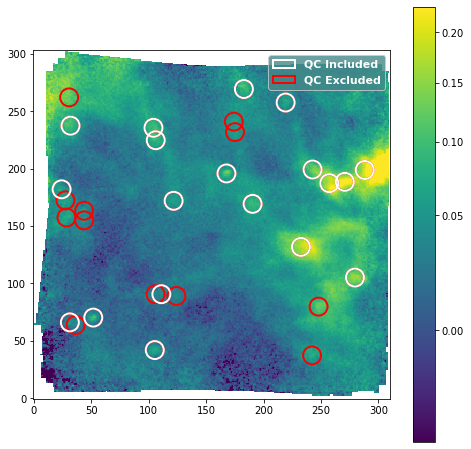

In [268]:
#now let's examine which sources didn't pass the cuts - overplot on the image to see if it looks first order reasonable

#get source coordinates for the snr cut table
cutsc=mtcut['sky_centroid'] 

#Compare which sources are included/excluded
source_aperture =SkyCircularAperture(cutsc, r=6*u.arcsec)

#convert to pixel coords for plotting
pix_aperture_source = source_aperture.to_pixel(wcsmap)


#show figure with apertures overlayed
plt.figure(figsize=(8,8))
norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm, interpolation='nearest',origin='lower')
plt.colorbar()
#plt.xlim(40, 140)
#plt.ylim(50, 125)


ap_patches = pix_aperture.plot(color='red', lw=2,
                           label='QC Excluded')
ap_patches_new = pix_aperture_source.plot(color='white', lw=2,
                           label='QC Included')

handles = (ap_patches_new[0],ap_patches[0])
plt.legend(loc='best', facecolor='#458989', labelcolor='white',
          handles=handles, prop={'weight': 'bold', 'size': 11})
plt.show()

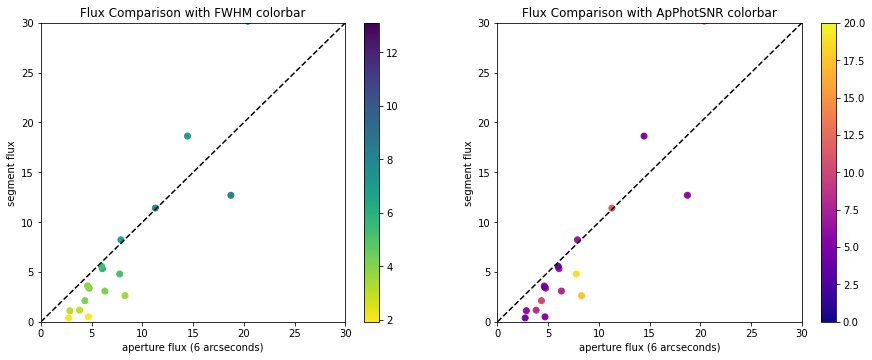

In [269]:
#a few diagnostic plots to examine segment and aperture fluxes
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))

ax1.set_title('Flux Comparison with FWHM colorbar')
p1=ax1.scatter(mtcut['aper_sum_bkgsub_6as'],mtcut['segment_flux'],c=mtcut['fwhm']*0.768, cmap='viridis_r')
fig.colorbar(p1, ax=ax1)
ax1.plot([0,30],[0,30],'k--')
ax1.set_xlabel('aperture flux (6 arcseconds)')
ax1.set_ylabel('segment flux')
ax1.set_xlim(0,30)
ax1.set_ylim(0,30)

ax2.set_title('Flux Comparison with ApPhotSNR colorbar')
p2=ax2.scatter(mtcut['aper_sum_bkgsub_6as'],mtcut['segment_flux'],c=mtcut['aper_snr_6as'], cmap='plasma',vmin=0,vmax=20)
fig.colorbar(p2, ax=ax2)
ax2.plot([0,30],[0,30],'k--')
ax2.set_xlabel('aperture flux (6 arcseconds)')
ax2.set_ylabel('segment flux')
ax2.set_xlim(0,30)
ax2.set_ylim(0,30)


plt.show()

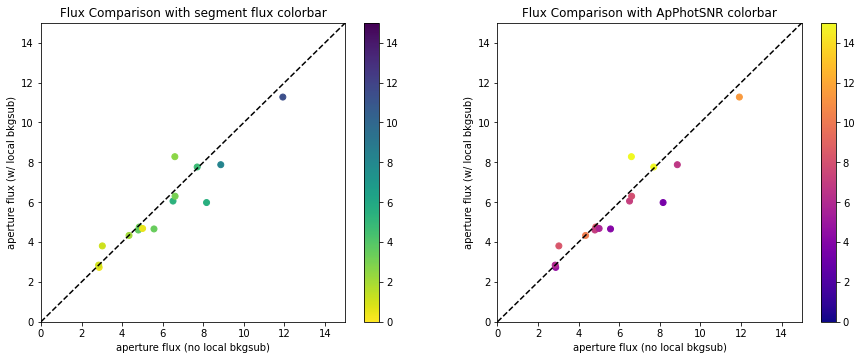

In [270]:
#a few diagnostic plots to examine background contributions to aperture flux
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))

ax1.set_title('Flux Comparison with segment flux colorbar')
p1=ax1.scatter(mtcut['aperture_sum_6as'],mtcut['aper_sum_bkgsub_6as'],c=mtcut['segment_flux'], cmap='viridis_r',vmin=0,vmax=15)
fig.colorbar(p1, ax=ax1)
ax1.plot([0,30],[0,30],'k--')
ax1.set_xlabel('aperture flux (no local bkgsub)')
ax1.set_ylabel('aperture flux (w/ local bkgsub)')
ax1.set_xlim(0,15)
ax1.set_ylim(0,15)

ax2.set_title('Flux Comparison with ApPhotSNR colorbar')
p2=ax2.scatter(mtcut['aperture_sum_6as'],mtcut['aper_sum_bkgsub_6as'],c=mtcut['aper_snr_6as'], cmap='plasma',vmin=0,vmax=15)
fig.colorbar(p2, ax=ax2)
ax2.plot([0,30],[0,30],'k--')
ax2.set_xlabel('aperture flux (no local bkgsub)')
ax2.set_ylabel('aperture flux (w/ local bkgsub)')
ax2.set_xlim(0,15)
ax2.set_ylim(0,15)


plt.show()

In [271]:
#write out the resulting table to file
ascii.write(mtcut, field+'_25um_cat_qcuts.dat', overwrite=True)